0.598214041812
0


/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


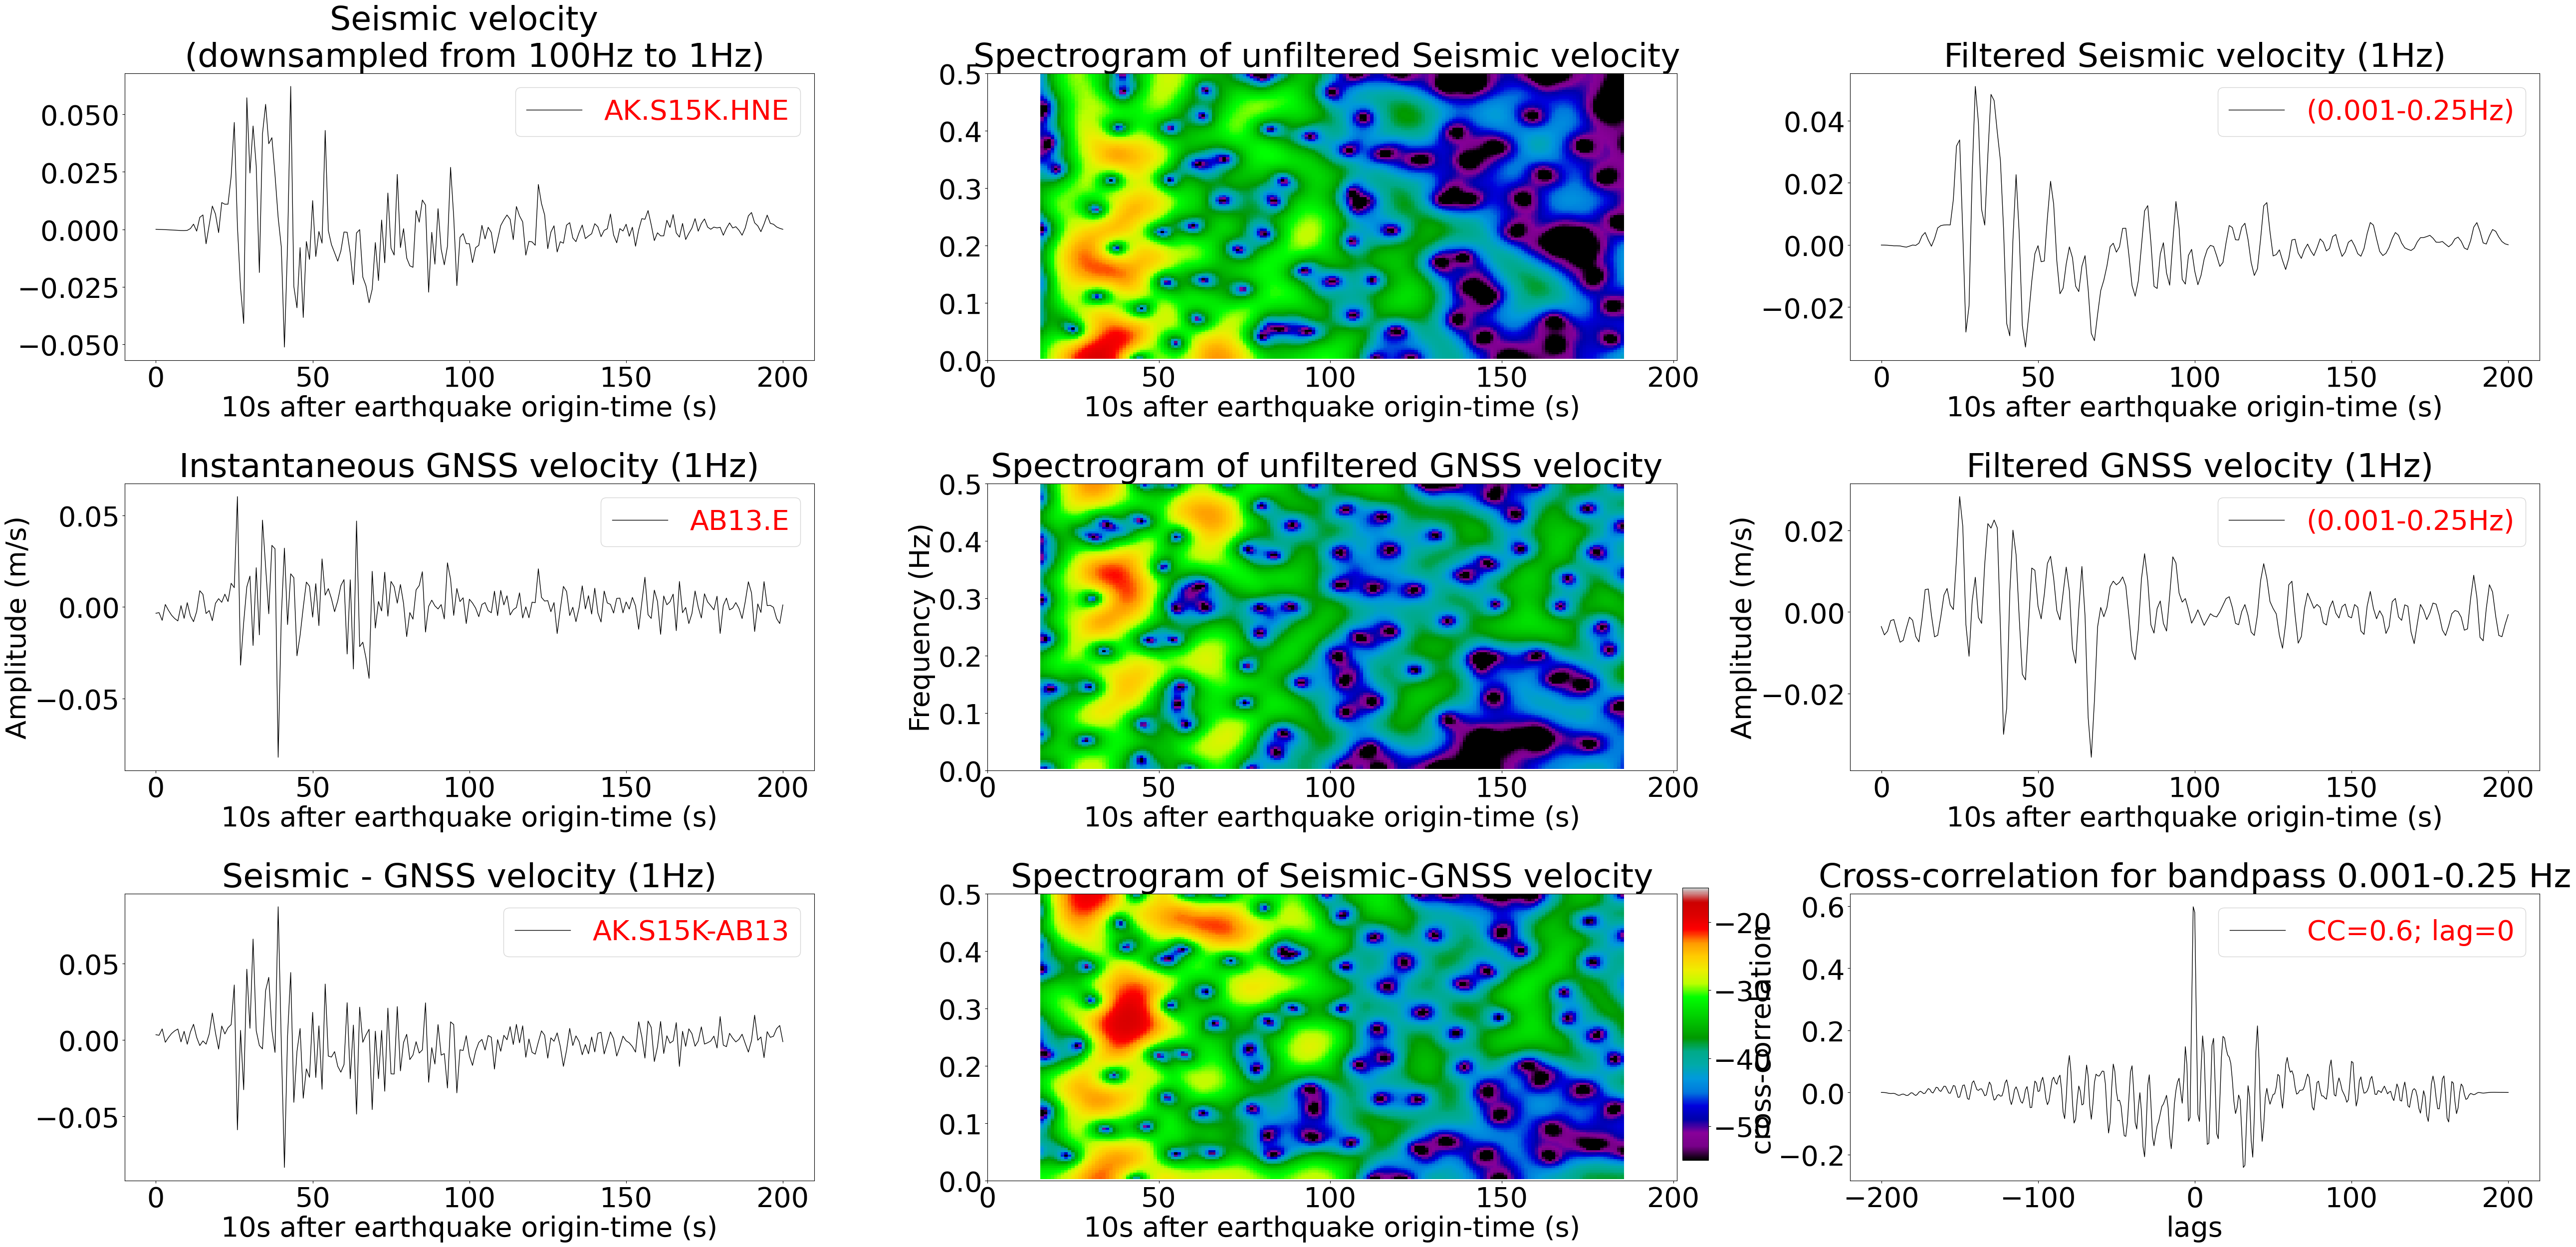

In [10]:
######## GNSS instavel Vs strong-motion derived velocity analysis and plots ##################
################################## Scipy version #############################################
####################################### Goals ################################################
#     1) Read a GNSS instavel and convert it into an obspy stream
#     2) Filter instavel
#     3) Load acceleration from IRIS client
#     4) Filter and integrate strong-motion acceleration to corresponding velocity
#     5) Subtract/find difference between GNSS and strong motion veocity
#     6) Subtract the difference from GNSS and plot trace
#     7) cross-correlate and plot both versions
##############################################################################################

from obspy import UTCDateTime 				
from obspy import Trace
from obspy import Stream
from obspy import read_inventory
from obspy.signal.cross_correlation import correlate
from obspy.clients.fdsn import Client 		
client=Client("IRIS")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.cm as cmx
import datetime

def compute_shift(cc):
    zero_index = int(len(cc) / 2) - 1
    shift = zero_index - np.argmax(cc)
    return shift

# READ INSTAVEL ASCII FILE
infile = 'Chignik_phase_vels/ab13_1hz.L2.igr.phase_vels'
site = np.genfromtxt(infile, dtype=None, encoding=None, names=['date','time','dt','lat','lon','height','vx', 'vy', 'vz', 'sigx', 'sigy', 'sigz', 'vdt', 'vn', 've', 'vu', 'sign', 'sige', 'sigu'])

# CREATE AN EMPTY STREAM AND POPULATE WITH INSTAVEL DATA
st_gnss_ve = Stream(Trace())
st_gnss_ve[0].stats.network = '--'
st_gnss_ve[0].stats.station = 'AB13'
st_gnss_ve[0].stats.channel = 'IVE'       # for [I]nst[V]el [E] component]
st_gnss_ve[0].stats.starttime = site["date"][0] + 'T' + site["time"][0]
st_gnss_ve[0].stats.sampling_rate = 1
st_gnss_ve[0].stats.calib = 1
st_gnss_ve[0].data = site['ve']
st_gnss_ve[0].detrend('linear')
st_gnss_ve[0].detrend('demean')
dt = UTCDateTime("2021-07-29T06:15:47.000000Z")
st_gnss_ve[0].trim(dt+10, dt+210)

st_gnss_f = st_gnss_ve[0].copy()
st_gnss_f.filter('bandpass', freqmin=0.001, freqmax=0.25, corners=4, zerophase=True)

# LOAD ONE SEISMIC ACCELERATION STREAM FROM IRIS DMC
start = UTCDateTime("2021-07-29T06:15:56.998400Z")
st_seis_ae = client.get_waveforms('AK', 'S15K', "*", 'HNE', (start), (start+200), attach_response=True)

# TIDY UP ACCELERATION TRACE
st_seis_ae[0].remove_response(inventory=None, output="ACC", plot=False)
st_seis_ae[0].detrend('linear')
st_seis_ae[0].detrend('demean')

# CREATE A SEISMIC VELOCITY TRACE
st_seis_ve = st_seis_ae[0].copy()
st_seis_ve.integrate(method='cumtrapz')
hz = st_seis_ve.data[::100]   # Brute-force 'downsampling' of strong-motion derived velocity to 1 Hz post-filtering and -integration

# CREATE AN EMPTY STREAM AND POPULATE WITH 1Hz STRONG-MOTION DERIVED VELOCITY DATA
st_sm_ve = Stream(Trace())
st_sm_ve[0].stats.network = 'AK'
st_sm_ve[0].stats.station = 'S15K'
st_sm_ve[0].stats.channel = 'HNE'    
st_sm_ve[0].stats.starttime = UTCDateTime("2021-07-29T06:15:57.0Z")
st_sm_ve[0].stats.sampling_rate = 1
st_sm_ve[0].stats.calib = 1
st_sm_ve[0].data = hz

st_sm_f = st_sm_ve[0].copy()
st_sm_f.filter('bandpass', freqmin=0.001, freqmax=0.25, corners=4, zerophase=True)

# DIFFERENCE
diff_ve = Stream(Trace())
diff_ve[0].stats.network = 'AK'
diff_ve[0].stats.station = 'AK.S15K-AB13'
diff_ve[0].stats.channel = 'HNE'    
diff_ve[0].stats.starttime = UTCDateTime("2021-07-29T06:15:57.0Z")
diff_ve[0].stats.sampling_rate = 1
diff_ve[0].stats.calib = 1
diff_ve[0].data = ((st_sm_ve[0].data)-(st_gnss_ve[0].data))

# NORMALIZE EACH TRACE WITH ITS ABSOLUTE MAXIMUM
#st_gnss_ve[0].normalize()
#st_gnss_f.normalize()
#st_sm_ve[0].normalize()
#st_sm_f.normalize()
#diff_ve[0].normalize()

# CROSS CORRELATION
lags = np.arange(-200, 201)  
cc = correlate(st_gnss_f.data, st_sm_f.data, 200)
print(max(cc))
print(compute_shift(cc))

# CREATE STREAMS WITH ALL TRACES AND PLOT THEM
plt.rcParams['figure.figsize'] = [52,26]
plt.rcParams.update({'font.size': 40})
#plt.style.use('seaborn')

fig, ax = plt.subplots(3,3)
ax[0,0].plot(st_sm_ve[0].times(), st_sm_ve[0].data, 'k-', linewidth=1, label=(st_sm_ve[0].stats['network'])+'.'+(st_sm_ve[0].stats['station'])+'.'+(st_sm_ve[0].stats['channel']))
ax[0,0].set_title(f'Seismic velocity \n (downsampled from 100Hz to 1Hz)')
#ax[0,0].set_ylabel('Normalized amplitude')
ax[0,0].set_xlabel('10s after earthquake origin-time (s)', fontsize=40)
ax[1,0].plot(st_gnss_ve[0].times(), st_gnss_ve[0].data, 'k-', linewidth=1, label=(st_gnss_ve[0].stats['station'])+'.E')
ax[1,0].set_title(f'Instantaneous GNSS velocity (1Hz)')
ax[1,0].set_ylabel('Amplitude (m/s)')
ax[1,0].set_xlabel('10s after earthquake origin-time (s)')
ax[2,0].plot(diff_ve[0].times(), diff_ve[0].data, 'k-', linewidth=1, label=diff_ve[0].stats['station'])
ax[2,0].set_title(f'Seismic - GNSS velocity (1Hz)')
#ax[2,0].set_ylabel('Normalized amplitude')
ax[2,0].set_xlabel('10s after earthquake origin-time (s)')


st_sm_ve[0].spectrogram(axes=ax[0,1], show=True, samp_rate=st_sm_ve[0].stats.sampling_rate, dbscale=True,  
                        per_lap=0.99, wlen=45, log=False, cmap='nipy_spectral')

ax[0, 1].set_title(f'Spectrogram of unfiltered Seismic velocity ')
#ax[0, 1].set_ylabel('Frequency (Hz)')
ax[0, 1].set_xlabel('10s after earthquake origin-time (s)')
ax[0, 1].set_ylim((0,0.5))
ax[0, 1].images[0].set_clim(vmin=-55, vmax=-15)
#mappable = ax[0,1].images[0]
#ax13 = fig.add_axes([0.99, 0.412, 0.01, 0.21])
#plt.colorbar(mappable=mappable, cax=ax13)

st_gnss_ve[0].spectrogram(axes=ax[1,1], show=True, samp_rate=st_gnss_ve[0].stats.sampling_rate, dbscale=True, 
                          per_lap=0.99, wlen=45, log=False, cmap='nipy_spectral')
ax[1, 1].set_title(f'Spectrogram of unfiltered GNSS velocity ')
ax[1, 1].set_ylabel('Frequency (Hz)')
ax[1, 1].set_xlabel('10s after earthquake origin-time (s)')
ax[1, 1].set_ylim((0,0.5))
ax[1, 1].images[0].set_clim(vmin=-55, vmax=-15)
#mappable = ax[1,1].images[0]
#ax23 = fig.add_axes([0.92, 0.738, 0.01, 0.21])
#plt.colorbar(mappable=mappable, cax=ax23)

diff_ve[0].spectrogram(axes=ax[2,1], show=True, samp_rate=diff_ve[0].stats.sampling_rate, dbscale=True, 
                       per_lap=0.99, wlen=45, log=False, cmap='nipy_spectral')
ax[2, 1].set_title(f'Spectrogram of Seismic-GNSS velocity')
#ax[2, 1].set_ylabel('Frequency (Hz)')
ax[2, 1].set_xlabel('10s after earthquake origin-time (s)')
ax[2, 1].set_ylim((0,0.5))
ax[2, 1].images[0].set_clim(vmin=-55, vmax=-15)
mappable = ax[2,1].images[0]
ax33 = fig.add_axes([0.658, 0.086, 0.01, 0.21])
plt.colorbar(mappable=mappable, cax=ax33)

ax[0,2].plot(st_sm_f.times(), st_sm_f.data, 'k-', linewidth=1, label='(0.001-0.25Hz)')
ax[0,2].set_title(f'Filtered Seismic velocity (1Hz)')
#ax[0,2].set_ylabel('Normalized amplitude')
ax[0,2].set_xlabel('10s after earthquake origin-time (s)')
ax[1,2].plot(st_gnss_f.times(), st_gnss_f.data, 'k-', linewidth=1, label='(0.001-0.25Hz)')
ax[1,2].set_title(f' Filtered GNSS velocity (1Hz)')
ax[1,2].set_ylabel('Amplitude (m/s)')
ax[1,2].set_xlabel('10s after earthquake origin-time (s)')
ax[2,2].plot(lags, cc, 'k', linewidth=1, label='CC=0.6; lag=0')
ax[2,2].set_title(f'Cross-correlation for bandpass 0.001-0.25 Hz')
ax[2,2].set_ylabel('cross-correlation')
ax[2,2].set_xlabel('lags')
plt.tight_layout()

# TRACE LEGENDS
for row in ax[:,0]:
    ll = row.legend(loc=1)
    plt.setp(ll.get_texts(), color='red') #color legend
for row in ax[:,2]:
    ll = row.legend(loc=1)
    plt.setp(ll.get_texts(), color='red') #color legend

ll = ax[2,2].legend(loc=1)
plt.setp(ll.get_texts(), color='red') #color legend

plt.show()
fig.savefig("S15K:AB13amp_db.pdf")
fig.savefig("S15K:AB13amp_db.png")
